In [2]:
import networkx as nx
import matplotlib as plt
import numpy as np

In [19]:
#make new graph
g = nx.DiGraph()
g.add_node('a', values = {'score':120, 'movelist': '12345'})
g.add_node('b',values = {'score':180, 'movelist': '6789'})
g.add_node('fen',score = 100, movelist = 'abcd')
g.add_edge('a','b')
g.add_edge('a', 'fen')
g.add_edge('fen', 'a')
g.add_edge('a','c')

In [45]:
g.nodes

NodeView(('a', 'b'))

In [46]:
nx.get_node_attributes(g, 'values')['a']

{'score': 120, 'movelist': '12345'}

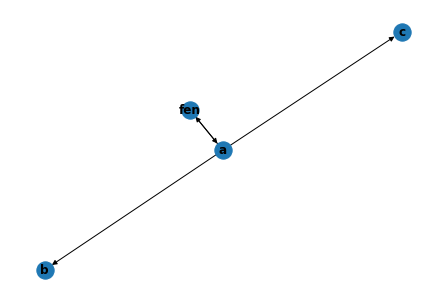

In [20]:
nx.draw(g, with_labels=True, font_weight='bold')


In [14]:
name = 'fen'
'd' not in g.nodes

True

In [60]:
def get_sf(g,x):
    for neighbor in g.neighbors(x):
        print(g.nodes[neighbor]["values"])

In [61]:
get_sf(g,'a')

{'score': 180, 'movelist': '6789'}


In [ ]:
g = nx.Digraph()

for string in stringList:
    board = chess.Board()
    moveString = ''
    for move in string:
        moveString += move + ' '
        parentId = ''
        try: 
            board.push_san(move) #push the move to the board
            currFen = board.fen() #get the fen from the board
            #(BASH SCRIPT TO GET COUNT : takes string returns number of lines, search for movestring+ " ")
            if(currFen not in g.nodes & (count < X)): #only add nodes if the sequence has not yet occured (HOW TO CHECK?) and they are frequent enough 
                stockfish = engine.analyse(board, chess.engine.Limit(time=0.05)) #get stockfish score of fen
                g.add_node(currFen, 
                           score = float(str(stockfish['score'])), 
                           movelist = moveString)
                g.add_edge(parentId, currFen)
            parentID = currFen
        except: #skip any errors in the notation that cannot be pushed to a board
            continue
        

In [ ]:
tree = Tree() #instantiate tree
tree.create_node('root', 'root', data = 1)

X = 6 #set pruning limit (don't add moves with less than X instances)
parentID = ''
for string in stringList: #loop through pre-processed games now as san strings
    board = chess.Board() #instantiate blank board
    moveString = '' #instantiate empty list to append moves to (for unique id)
    #set parent ID to root
    count = 1
    for move in string: #loop through all moves in single game
        moveString +=move #check if FEN can work
        try:
            board.push_san(move) #push the move to the board
            currFen = board.fen() #get the fen from the board
            #count = 1 #count the instances of this sequence of moves in mega game file (grep?)
            #(BASH SCRIPT TO GET COUNT : takes string returns number of lines, search for movestring+ " ")
            if((tree.get_node(moveString) == None) & (count < X)): #only add nodes if the sequence has not yet occured (HOW TO CHECK?) and they are frequent enough 
                stockfish = engine.analyse(board, chess.engine.Limit(time=0.05)) #get stockfish score of fen
                if(string[0] == move): #handle first moves, add to root #handle repeated opening (check length)
                    tree.create_node(tag = move, 
                                     identifier = moveString, 
                                     parent = 'root', 
                                     data =[count,int(re.split('\+|-', str(stockfish['score']))[1])])
                                     #data = {cnt: count, sf: stockfish['score']}) #store count of instances and associated stockfish score
                else:
                    tree.create_node(tag = move, #add node, tag is move, unique id is sequence of moves, 
                                     identifier = moveString, 
                                     parent = parentID, #parent is last set of moves
                                     data =[count,int(re.split('\+|-', str(stockfish['score']))[1])]) # get rid of re.split conert to float
                                 #data = {"cnt": count, "sf": stockfish['score']}) #store count of instances and associated stockfish score
            count+=1
            parentID = moveString
        except:
            continue